## Preparing the data

In [22]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

In [47]:
# change working directory to model folder
os.chdir("C:\\Users\\brian\\Desktop\\minor\\AI project\\model")

# save the data from the csv file and divide Pawpularity score by 100
train_data = pd.read_csv('petfinder-pawpularity-score/train.csv')
# train_data = train_data[train_data.Pawpularity != 100]

# check if the data was read correctly and if there are NaN values
display(train_data.head(5))
print(f'NaN amount: {train_data.isnull().sum().sum()}')

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


NaN amount: 0


In [48]:
def load_images_from_folder(folder, data = [], size=64):

    samples = len(data)
    images = [None] * samples


    for count, filename in enumerate(os.listdir(folder)):
        name = filename.strip('.jpg')
        index = train_data[train_data['Id']==name].index.item()

        img = cv2.resize(cv2.imread(os.path.join(folder,filename)), (size, size))

        if img is not None:
            images[index] = img

        if count % 1000 == 0:
            print(f"{round(count / samples *100, 0)}%")

    return np.array(images), np.array(data['Pawpularity']), np.array(data['Id'])

data_images, data_labels, data_names = load_images_from_folder('petfinder-pawpularity-score/train', data = train_data)

print(f'Training labels loaded: {data_images.shape}')

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
61.0%
71.0%
81.0%
91.0%
Training labels loaded: (9912, 64, 64, 3)


## Making the image model

In [74]:
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing, utils
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU

In [77]:
def train_and_evaluate(model, train_x, train_y, preprocess={}, epochs=20, augment={}, folds = 5):
    ''' Make the model to train and evaluate the data'''

    from sklearn.model_selection import KFold
    kfold = KFold(n_splits=folds)

    cv_scores= [] 

    for train, test in kfold.split(train_x, train_y):
      # compile the model using adam as optimizer with mean squared error as loss function
        model.compile(optimizer='adam',
                loss='MSE',
                metrics=['RootMeanSquaredError'])

        train_gen = preprocessing.image.ImageDataGenerator(preprocess, augment)
        train_gen.fit(train_x[train]) 

        val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
        val_gen.fit(train_x[test])

      # estimate the model using the compile 
        history = model.fit(train_gen.flow(train_x[train], np.array(train_y)[train]), epochs=epochs, 
                          validation_data=val_gen.flow(train_x[test], np.array(train_y)[test]))

        fig, axs = plt.subplots(1,2,figsize=(20,5)) 

      # plot the learning curves
        for i, metric in enumerate(['loss', 'RootMeanSquaredError']):
            axs[i].plot(history.history[metric])
            axs[i].plot(history.history['val_'+metric])
            axs[i].legend(['training', 'validation'], loc='best')

            axs[i].set_title('Model '+metric)
            axs[i].set_ylabel(metric)
            axs[i].set_xlabel('epoch')

        plt.show()

        score = model.evaluate(val_gen.flow(train_x[test], np.array(train_y)[test]))[1]

        cv_scores.append(score)

        print('cv_scores:', cv_scores)
    print('Mean RMSE:', np.mean(cv_scores))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 248 steps, validate for 62 steps
Epoch 1/20
248/248 [==============================] - 5s 18ms/step - loss: 1210.2454 - RootMeanSquaredError: 31.3457 - val_loss: 1276.4840 - val_RootMeanSquaredError: 34.8638
Epoch 2/20
248/248 [==============================] - 3s 14ms/step - loss: 1059.5138 - RootMeanSquaredError: 29.5824 - val_loss: 1205.0420 - val_RootMeanSquaredError: 33.4415
Epoch 3/20
248/248 [==============================] - 3s 14ms/step - loss: 982.2272 - RootMeanSquaredError: 28.6868 - val_loss: 1208.9112 - val_RootMeanSquaredError: 34.0704
Epoch 4/20
248/248 [==============================] - 3s 14ms/step - loss: 981.9742 - RootMeanSquaredError: 28.9752 - val_loss: 1173.5118 - val_RootMeanSquaredError: 33.5769
Epoch 5/20
248/248 [==============================] - 3s 14ms/step - loss: 915.2837 - RootMeanSquaredError: 28.1694 - val_loss: 1198.5850 - val_RootMeanSquaredError: 33.4540
Epoch 6/20
248/248 [===============

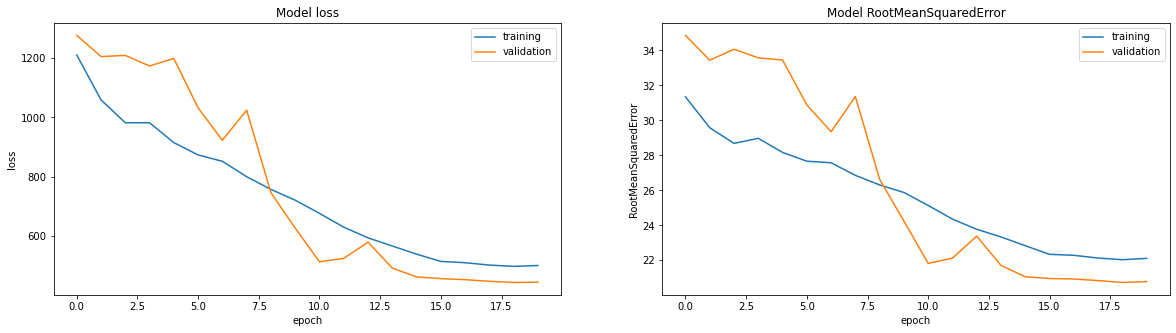

  ...
    to  
  ['...']
62/62 [==============================] - 0s 4ms/step - loss: 445.0579 - RootMeanSquaredError: 20.7795
cv_scores: [20.779518]
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 248 steps, validate for 62 steps
Epoch 1/20
248/248 [==============================] - 5s 20ms/step - loss: 504.7141 - RootMeanSquaredError: 22.1923 - val_loss: 448.7042 - val_RootMeanSquaredError: 20.8875
Epoch 2/20
248/248 [==============================] - 3s 14ms/step - loss: 499.8135 - RootMeanSquaredError: 22.0927 - val_loss: 494.3394 - val_RootMeanSquaredError: 21.9385
Epoch 3/20
248/248 [==============================] - 3s 14ms/step - loss: 500.8568 - RootMeanSquaredError: 22.1326 - val_loss: 449.8011 - val_RootMeanSquaredError: 20.9557
Epoch 4/20
248/248 [==============================] - 3s 14ms/step - loss: 496.5588 - RootMeanSquaredError: 22.0412 - val_loss: 445.6693 - val_RootMeanSquaredError: 20.8470
Epoch 5/20
248/248 [==============================] - 3s 14ms/ste

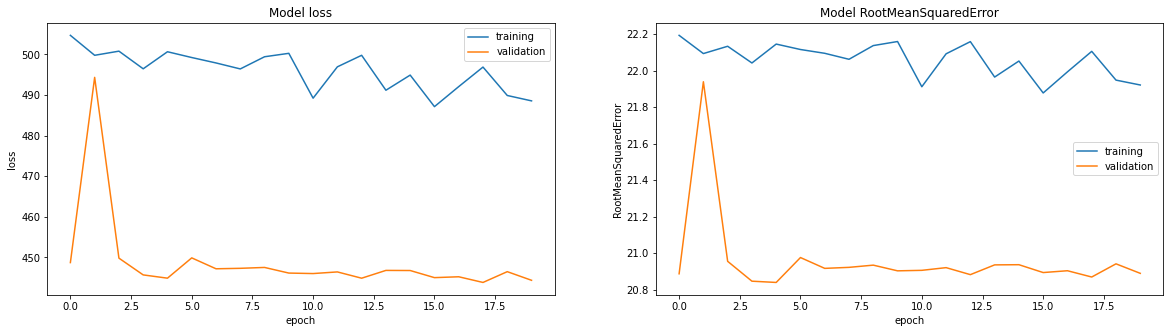

  ...
    to  
  ['...']
62/62 [==============================] - 0s 4ms/step - loss: 444.5723 - RootMeanSquaredError: 20.8899
cv_scores: [20.779518, 20.889933]
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 248 steps, validate for 62 steps
Epoch 1/20
248/248 [==============================] - 4s 18ms/step - loss: 490.1443 - RootMeanSquaredError: 21.9636 - val_loss: 450.1168 - val_RootMeanSquaredError: 21.0227
Epoch 2/20
248/248 [==============================] - 3s 14ms/step - loss: 485.8330 - RootMeanSquaredError: 21.8686 - val_loss: 448.9698 - val_RootMeanSquaredError: 20.9957
Epoch 3/20
248/248 [==============================] - 3s 14ms/step - loss: 487.4749 - RootMeanSquaredError: 21.9076 - val_loss: 448.5334 - val_RootMeanSquaredError: 20.9876
Epoch 4/20
248/248 [==============================] - 3s 14ms/step - loss: 484.0247 - RootMeanSquaredError: 21.8317 - val_loss: 448.5648 - val_RootMeanSquaredError: 20.9919
Epoch 5/20
248/248 [==============================] - 

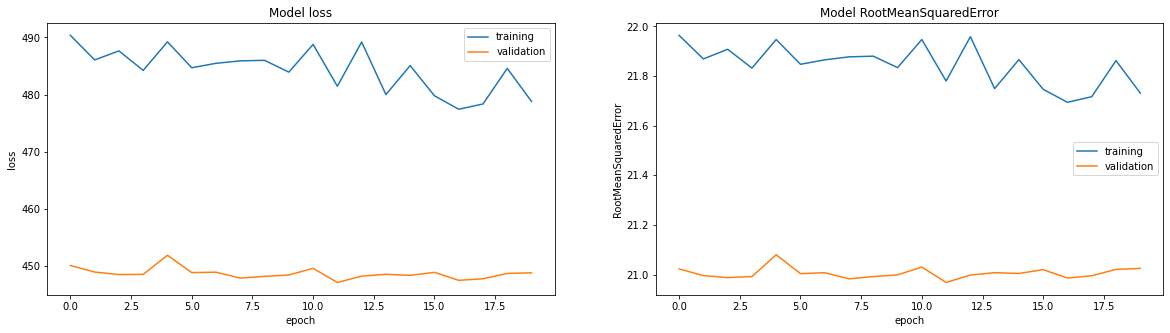

  ...
    to  
  ['...']
62/62 [==============================] - 0s 4ms/step - loss: 448.5756 - RootMeanSquaredError: 21.0247
cv_scores: [20.779518, 20.889933, 21.024744]
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 248 steps, validate for 62 steps
Epoch 1/20
248/248 [==============================] - 5s 18ms/step - loss: 490.3336 - RootMeanSquaredError: 21.9982 - val_loss: 414.0496 - val_RootMeanSquaredError: 20.1904
Epoch 2/20
248/248 [==============================] - 3s 14ms/step - loss: 488.4954 - RootMeanSquaredError: 21.9557 - val_loss: 414.1156 - val_RootMeanSquaredError: 20.1938
Epoch 3/20
248/248 [==============================] - 3s 14ms/step - loss: 481.2897 - RootMeanSquaredError: 21.7914 - val_loss: 414.1969 - val_RootMeanSquaredError: 20.1973
Epoch 4/20
248/248 [==============================] - 3s 14ms/step - loss: 491.0441 - RootMeanSquaredError: 22.0165 - val_loss: 413.1824 - val_RootMeanSquaredError: 20.1708
Epoch 5/20
248/248 [=======================

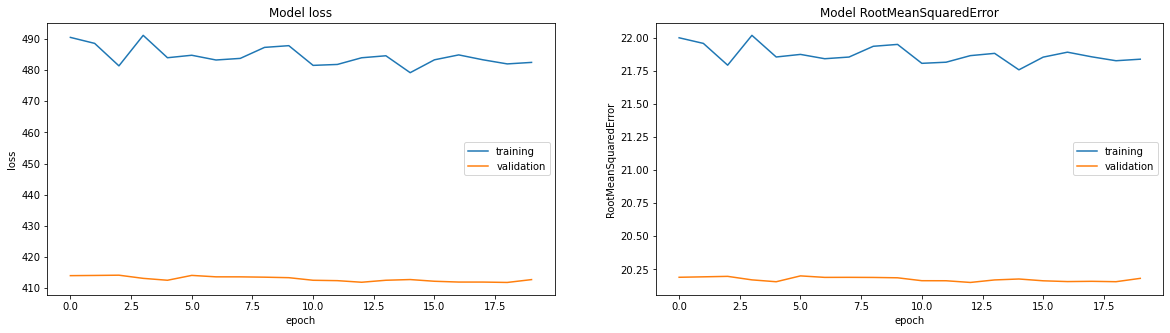

  ...
    to  
  ['...']
62/62 [==============================] - 0s 4ms/step - loss: 412.7360 - RootMeanSquaredError: 20.1822
cv_scores: [20.779518, 20.889933, 21.024744, 20.182224]
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 248 steps, validate for 62 steps
Epoch 1/20
248/248 [==============================] - 5s 18ms/step - loss: 478.4788 - RootMeanSquaredError: 21.7527 - val_loss: 424.3590 - val_RootMeanSquaredError: 20.4620
Epoch 2/20
248/248 [==============================] - 3s 14ms/step - loss: 474.5073 - RootMeanSquaredError: 21.6603 - val_loss: 425.1088 - val_RootMeanSquaredError: 20.483685 - RootMeanSquaredErr - ETA: 0s - loss: 484.1000 - RootMeanSquared
Epoch 3/20
248/248 [==============================] - 3s 14ms/step - loss: 474.3871 - RootMeanSquaredError: 21.6613 - val_loss: 423.8934 - val_RootMeanSquaredError: 20.4520
Epoch 4/20
248/248 [==============================] - 3s 14ms/step - loss: 479.5602 - RootMeanSquaredError: 21.7792 - val_loss: 423.4858 

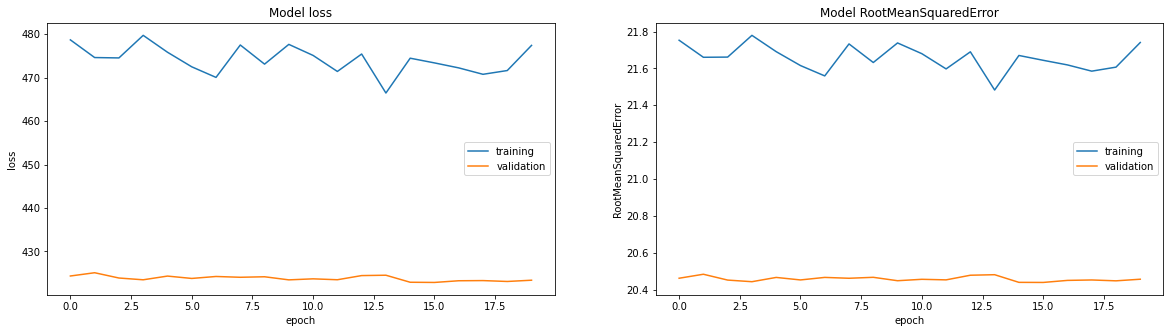

  ...
    to  
  ['...']
62/62 [==============================] - 0s 4ms/step - loss: 423.1496 - RootMeanSquaredError: 20.4566
cv_scores: [20.779518, 20.889933, 21.024744, 20.182224, 20.456642]
Mean RMSE: 20.666613


In [80]:
''' First model with 3 hidden layers, dropout, batchnormalization, activity regularizer,
  featurewise center and featurewise std normalization'''


# activity_regularizer=regularizers.l2(1e-3)
# kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),

model=tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
#model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1,activation=None))

preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}
augment = {'rotation_range' : 30, 'vertical_flip' : True, 'width_shift_range' : 0.25, 'height_shift_range' : 0.25}

# train the model and evaluate it with the test_data

train_and_evaluate(model, data_images, data_labels, preprocess=preprocess, epochs=20, augment = augment)

In [66]:
predictions = model.predict(data_images)
print(predictions[np.argmax(predictions)])
print(predictions[np.argmin(predictions)])

[67.189964]
[11.914236]


C:\Users\brian\anaconda3\envs\Jupyter\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


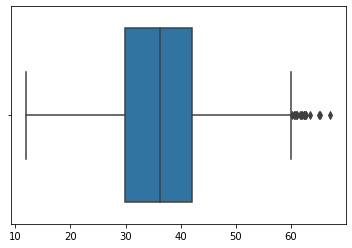

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.boxplot(predictions)
plt.show()

This dataset is from a competition in which you have to estimate the 8 images below, these are our scores as of now.

In [ ]:
test_images = []
test_names = []

# iterate over the test images
for filename in os.listdir('petfinder-pawpularity-score/test'):
    
    # get the names of the test images and save these in the list
    name = filename.strip('.jpg')
    test_names.append(name)
    
    # save the images 
    img = cv2.imread(os.path.join('petfinder-pawpularity-score/test',filename))
    if img is not None:
        test_images.append(img)

In [ ]:
# convert the list of images to an array
test_images = np.array(test_images)

# use the model to predict the pawpularity scores of the test images
model.predict(data_images)